In [21]:
import thicket as th
from glob import glob

files = glob("group-cali-files/**/*.cali")
data = th.Thicket.from_caliperreader(files)

(2/2) Creating Thicket: 100%|██████████| 559/559 [00:10<00:00, 52.15it/s]


In [22]:

data.metadata_columns_to_perfdata("input_size")
data.metadata_columns_to_perfdata("num_procs")
data.metadata_columns_to_perfdata("input_type")
data.metadata_columns_to_perfdata("algorithm")
data.metadata_columns_to_perfdata("cmdline")
data.metadata_columns_to_perfdata("opts:output")

# data.metadata[(data.metadata['opts:output'] == 'cali-files/28-2-2-0.cali')]
# data.metadata

In [23]:
df = data.dataframe.reset_index()
# df = df.dropna()
df[(df['profile'] == 6767565383676)]


,node,profile,nid,spot.channel,Min time/rank,Max time/rank,Avg time/rank,Total time,Variance time/rank,Min time/rank (exc),...,Calls/rank (avg),Calls/rank (max),Calls (total),name,input_size,num_procs,input_type,algorithm,cmdline,opts:output
196,"{'name': 'main', 'type': 'function'}",6767565383676,1.0,"(regionprofile,)",43.614000,46.804500,45.209300,90.418600,NaN,0.458851,...,NaN,NaN,NaN,main,268435456,2,2,Merge Sort,"[./merge_sort, 28, 2, 0]",cali-files/28-2-2-0.cali
756,"{'name': 'data_init_runtime', 'type': 'function'}",6767565383676,2.0,"(regionprofile,)",7.923720,7.924670,7.924200,15.848400,NaN,7.923720,...,1.0,1.0,2.0,data_init_runtime,268435456,2,2,Merge Sort,"[./merge_sort, 28, 2, 0]",cali-files/28-2-2-0.cali
1316,"{'name': 'comp', 'type': 'function'}",6767565383676,3.0,"(regionprofile,)",34.873500,37.094100,35.983800,71.967600,NaN,0.000060,...,1.0,2.0,3.0,comp,268435456,2,2,Merge Sort,"[./merge_sort, 28, 2, 0]",cali-files/28-2-2-0.cali
1876,"{'name': 'comp_large', 'type': 'function'}",6767565383676,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,268435456,2,2,Merge Sort,"[./merge_sort, 28, 2, 0]",cali-files/28-2-2-0.cali
2436,"{'name': 'comp_small', 'type': 'function'}",6767565383676,4.0,"(regionprofile,)",34.873500,35.058800,34.966100,69.932300,NaN,34.873500,...,1.0,1.0,2.0,comp_small,268435456,2,2,Merge Sort,"[./merge_sort, 28, 2, 0]",cali-files/28-2-2-0.cali
2996,"{'name': 'comp_large', 'type': 'function'}",6767565383676,7.0,"(regionprofile,)",2.035180,2.035180,2.035180,2.035180,NaN,2.035180,...,1.0,1.0,1.0,comp_large,268435456,2,2,Merge Sort,"[./merge_sort, 28, 2, 0]",cali-files/28-2-2-0.cali
3556,"{'name': 'comm', 'type': 'function'}",6767565383676,5.0,"(regionprofile,)",0.172375,0.357932,0.265153,0.530307,NaN,0.000023,...,1.0,1.0,2.0,comm,268435456,2,2,Merge Sort,"[./merge_sort, 28, 2, 0]",cali-files/28-2-2-0.cali
4116,"{'name': 'comm_large', 'type': 'function'}",6767565383676,6.0,"(regionprofile,)",0.172352,0.357890,0.265121,0.530242,NaN,0.172352,...,1.0,1.0,2.0,comm_large,268435456,2,2,Merge Sort,"[./merge_sort, 28, 2, 0]",cali-files/28-2-2-0.cali
4676,"{'name': 'comm_small', 'type': 'function'}",6767565383676,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,268435456,2,2,Merge Sort,"[./merge_sort, 28, 2, 0]",cali-files/28-2-2-0.cali
5236,"{'name': 'comm_large', 'type': 'function'}",6767565383676,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,268435456,2,2,Merge Sort,"[./merge_sort, 28, 2, 0]",cali-files/28-2-2-0.cali


In [24]:
print(data.tree(["Avg time/rank"]))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2025.1.0

0.466 main
├─ 0.001 data_init_runtime
├─ 0.009 comp
│  ├─ nan comp_large
│  ├─ 0.008 comp_small
│  └─ 0.001 comp_large
├─ 0.001 comm
│  ├─ 0.001 comm_large
│  ├─ nan comm_small
│  └─ nan comm_large
└─ 0.001 correctness_check

Legend (Metric: Avg time/rank Min: 0.00 Max: 0.47 indices: {'profile': np.int64(12664303082)})
█ 0.42 - 0.47
█ 0.33 - 0.42
█ 0.23 - 0.33
█ 0.14 - 0.23
█ 0.05 - 0.14
█ 0.00 - 0.05

name User code    ◀  Only in left graph    ▶  Only in right graph



In [25]:
node_strings = ["comp_large", "comm", "main"]

## Strong Scaling Time Plots

In [26]:
import matplotlib.pyplot as plt
def plot_runtimes(x, ys, leg_labels, title, figname, inp_size):
    _, ax = plt.subplots()
    ax.plot(x, ys[0], 'x--', label=leg_labels[0], markersize=10)
    ax.plot(x, ys[1], '.--', label=leg_labels[1])
    # ax.plot(x, ys[2], 'o--', label=leg_labels[2], fillstyle='none')
    # ax.plot(x, ys[3], 'p--', label=leg_labels[3], fillstyle='none')
    ax.set_xscale('log', base=2)
    ax.set_xlabel(f"Number of Processes (log 2 scaled)")
    ax.set_ylabel("Time (s)")
    ax.set_title(f"{title} Time Strong Scaling (Input Size={inp_size})")
    ax.legend()
    # plt.savefig(f"plots/strong-time/{figname}.png", dpi=600, bbox_inches="tight")
    plt.show()

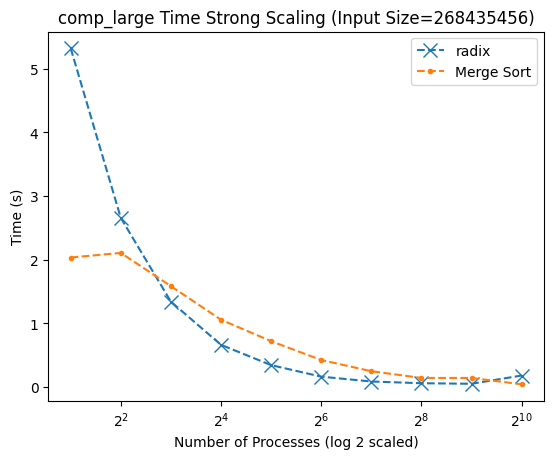

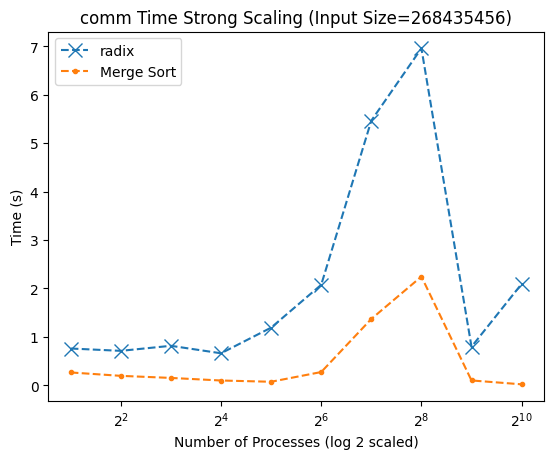

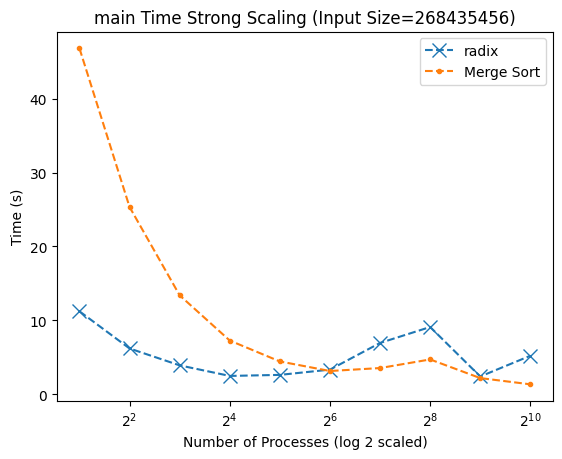

In [27]:
from copy import deepcopy


df = data.dataframe
df = df[df["Avg time/rank"].isna() == False]
data.dataframe = df

sub_data = data.groupby([ "algorithm", "input_size", "num_procs", "input_type"])
desired_size = 2**28
num_procs = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
algorithms = {"radix": [], "Merge Sort": []}

ys_time = {node : deepcopy(algorithms) for node in node_strings}

for cols, thic in sub_data.items():
    for node_string in node_strings:
        
        node = thic.get_node(node_string)
        algorithm = thic.dataframe.loc[node, "algorithm"].values[0]
        sort_level = thic.dataframe.loc[node, "input_type"].values[0]
        inp_size = int(thic.dataframe.loc[node, "input_size"].values.flatten()[0])
        name = thic.dataframe.loc[node, "name"].values[0]
        if (inp_size != desired_size or sort_level!=2):
            continue
        y_avg = float(thic.dataframe.loc[node, "Avg time/rank"].values.flatten()[0])

        ys_time[node_string][algorithm].append(y_avg)

for node_string in node_strings:
    leg_labels = list(ys_time[node_string].keys())
    ys = list(ys_time[node_string].values())
    
    plot_runtimes(num_procs, ys, leg_labels, node_string, None, desired_size)

## Strong Scaling Speedup

In [ ]:
def plot_speedup(x, ys, leg_labels, title, sort_level, figname):
    _, ax = plt.subplots()
    ax.plot(x, ys[0], 'x--', label=leg_labels[0], markersize=10)
    ax.plot(x, ys[1], '.--', label=leg_labels[1])
    # ax.plot(x, ys[2], 'o--', label=leg_labels[2], fillstyle='none')
    # ax.plot(x, ys[3], 'p--', label=leg_labels[3], fillstyle='none')
    ax.set_xscale('log', base=2)
    ax.set_xlabel(f"Number of Processes (log 2 scaled)")
    ax.set_ylabel("Speedup Factor")
    ax.set_title(f"{title} Speedup Factor Strong Scaling (Sort Level={sort_level})")
    ax.legend()
    # plt.savefig(f"plots/strong-speedup/{figname}.png", dpi=600, bbox_inches="tight")
    plt.show()

In [ ]:
for node in node_strings:
    y_scaling = []
    for sort, times in ys_time[node].items():
        runtimes = times
        speedup = [runtimes[0]/x for x in runtimes]
        y_scaling.append(speedup)
    plot_speedup(num_procs, y_scaling, leg_labels, node, "Random", None)

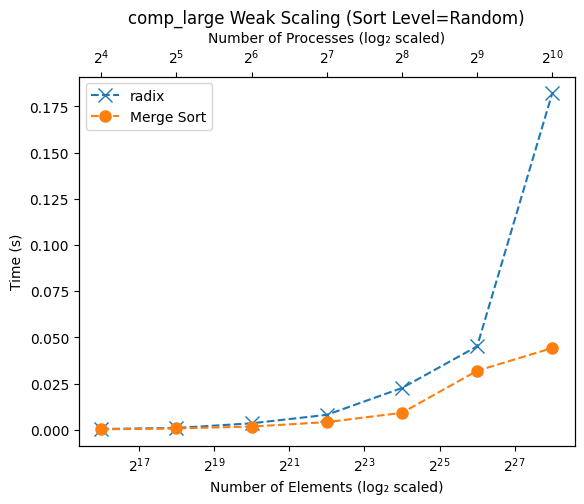

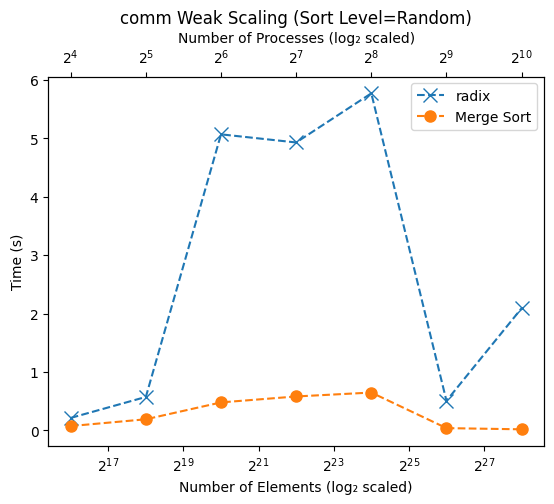

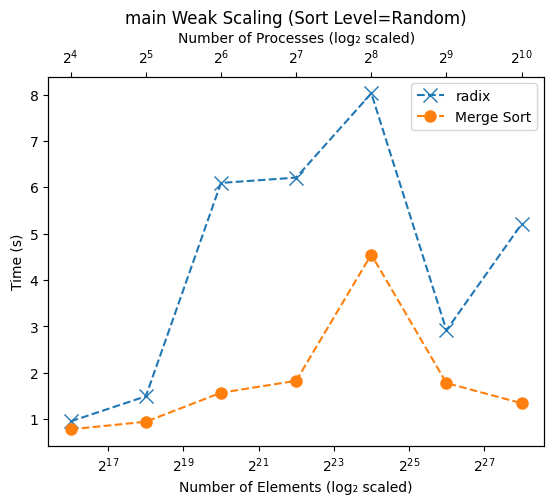

In [52]:
import matplotlib.pyplot as plt

df = data.dataframe
df = df[df["Avg time/rank"].isna() == False]
data.dataframe = df


def plot_runtimes_weak(x_proc, x_elem, ys, labels, title, sort_level, figname):
    """
    Plots weak scaling for two algorithms.

    Parameters:
    - x_proc: list of number of processes
    - x_elem: list of total number of elements
    - ys: list of two y-values lists [algo1_avg, algo2_avg]
    - labels: list of two algorithm names
    - title: region/node title
    - sort_level: e.g., 'Random'
    - figname: filename (unused if just showing)
    """
    _, ax = plt.subplots()
    ax2 = ax.twiny()

    # Plot two lines for the two algorithms
    ax.plot(x_elem, ys[0], 'x--', label=labels[0], markersize=10)
    ax.plot(x_elem, ys[1], 'o--', label=labels[1], markersize=8)

    # Add invisible lines to link processes on top axis
    ax2.plot(x_proc, ys[0], alpha=0)
    ax2.plot(x_proc, ys[1], alpha=0)

    # Set log scales
    ax.set_xscale('log', base=2)
    ax2.set_xscale('log', base=2)

    # Labels
    ax.set_xlabel("Number of Elements (log₂ scaled)")
    ax2.set_xlabel("Number of Processes (log₂ scaled)")
    ax.set_ylabel("Time (s)")
    ax.set_title(f"{title} Weak Scaling (Sort Level={sort_level})")
    ax.legend()
    plt.show()



import numpy as np
from itertools import product
from copy import deepcopy
int_to_string = {
    0: "Sorted",
    1: "Perturbed",
    2: "Random",
    3: "Reversed"
}
algorithms = {"radix": [], "Merge Sort": []}

sub_data = data.groupby(["input_size", "num_procs", "input_type", 'algorithm'])
allowed_procs = [16, 32, 64, 128, 256, 512, 1024]
allowed_elems = [2**x for x in (16, 18, 20, 22, 24, 26, 28)]
allowed_combs = list(zip(allowed_procs, allowed_elems))

levels = {"Random"}
ys = {node: {alg: {level: deepcopy(metrics) for level in levels} for alg in algorithms.keys()}
      for node in node_strings}

for cols, thic in sub_data.items():
   for node_string in node_strings:

      node = thic.get_node(node_string)
      sort_level = thic.dataframe.loc[node, "input_type"].values[0]
      algorithm = thic.dataframe.loc[node, "algorithm"].values[0]
      x_proc = int(thic.dataframe.loc[node, "num_procs"].values.flatten()[0])
      x_size = int(thic.dataframe.loc[node, "input_size"].values.flatten()[0])

      if (((x_proc, x_size) not in allowed_combs) or sort_level != 2):
         continue
      sort_level = int_to_string[sort_level]

      y_avg = float(
          thic.dataframe.loc[node, "Avg time/rank"].values.flatten()[0])
      ys[node_string][algorithm][sort_level]["Avg"].append(y_avg)


# Plot loop
for node_string in node_strings:
    for level in levels:
        ys_to_plot = []
        labels = []

        for algorithm in algorithms.keys():
            y_avg = ys[node_string][algorithm][level]["Avg"]
            if not y_avg:
                continue

            # Pad to match allowed_elems length
            y_avg += [np.nan]*(len(allowed_elems) - len(y_avg))
            ys_to_plot.append(y_avg)
            labels.append(algorithm)

        if len(ys_to_plot) != 2:
            continue  # skip if we don't have both algorithms

        plot_runtimes_weak(
            allowed_procs,
            allowed_elems,
            ys_to_plot,
            labels,
            node_string,
            level,
            f"{node_string}-{level}-weak"
        )